<a href="https://colab.research.google.com/github/zdiana/pp2-20B030130/blob/main/NLP_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import time
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

In [6]:
# setting
torch.manual_seed(42)
random.seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 1. download IMDB
dataset = load_dataset("imdb")
train_data = dataset['train'].shuffle(seed=42).select(range(1000))
test_data = dataset['test'].shuffle(seed=42).select(range(500))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
# 2. Tokenization (без padding, truncation будет в Dataset)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 200

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# 3. Кастомный Dataset
class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]
        tokens = tokenizer(text, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        return tokens["input_ids"].squeeze(0), label

train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
# 4. LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

VOCAB_SIZE = tokenizer.vocab_size
lstm_model = LSTMClassifier(VOCAB_SIZE, 100, 128, 2).to(DEVICE)

In [11]:
# 5. Обучение и оценка
def train(model, dataloader):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    start = time.time()
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader), time.time() - start

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

In [12]:
# 6. Результаты
loss, train_time = train(lstm_model, train_loader)
acc = evaluate(lstm_model, test_loader)

print(f"LSTM Accuracy: {acc:.4f}")
print(f"LSTM Train Time: {train_time:.2f} sec")

LSTM Accuracy: 0.5140
LSTM Train Time: 74.32 sec


In [13]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_heads=4, hidden_dim=256, num_layers=2, num_classes=2, max_len=200):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_len, embed_dim), requires_grad=False)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def _get_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x)

In [15]:
#initialization
transformer_model = TransformerClassifier(vocab_size=tokenizer.vocab_size).to(DEVICE)

trans_loss, trans_time = train(transformer_model, train_loader)
trans_acc = evaluate(transformer_model, test_loader)

In [16]:
print("\n--- differences of models ---")
print(f"LSTM       | Accuracy: {acc:.4f} | Time: {train_time:.2f} sec | Loss: {loss:.4f}")
print(f"Transformer| Accuracy: {trans_acc:.4f} | Time: {trans_time:.2f} sec | Loss: {trans_loss:.4f}")


--- differences of models ---
LSTM       | Accuracy: 0.5140 | Time: 74.32 sec | Loss: 0.6970
Transformer| Accuracy: 0.4900 | Time: 26.34 sec | Loss: 0.7109


In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
torch.manual_seed(42)
seq_len = 4
embed_dim = 8

In [19]:
X = torch.randn(seq_len, embed_dim)

In [20]:
# 1. Matrix
W_q = torch.randn(embed_dim, embed_dim)
W_k = torch.randn(embed_dim, embed_dim)
W_v = torch.randn(embed_dim, embed_dim)

# 2. Get Q, K, V
Q = X @ W_q
K = X @ W_k
V = X @ W_v

In [21]:
# 3. Attention scores (before softmax)
scores = Q @ K.T / torch.sqrt(torch.tensor(embed_dim, dtype=torch.float32))

# 4. using softmax by rows
attention_weights = F.softmax(scores, dim=1)

# 5. output self-attention
output = attention_weights @ V

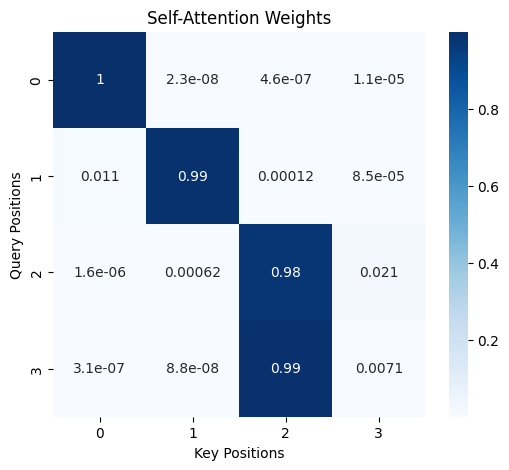

In [23]:
#visualization
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights.detach().numpy(), annot=True, cmap="Blues")
plt.title("Self-Attention Weights")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

In [24]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, hidden_dim=256, num_layers=2, num_classes=2, max_len=200, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Average pooling over sequence
        return self.classifier(x)


In [25]:
# We use the same tokenizer and Dataloader.

model = TransformerTextClassifier(vocab_size=tokenizer.vocab_size).to(DEVICE)

loss, train_time = train(model, train_loader)
acc = evaluate(model, test_loader)

print(f"Transformer From Scratch | Accuracy: {acc:.4f} | Time: {train_time:.2f} sec | Loss: {loss:.4f}")


Transformer From Scratch | Accuracy: 0.5200 | Time: 29.93 sec | Loss: 0.7506


In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

# download dataset
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)
dataset = dataset.rename_column("label", "labels")

# for the fast process
small_train = dataset["train"].select(range(1000))
small_test = dataset["test"].select(range(500))

In [29]:
#tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = small_train.map(tokenize_function, batched=True)
tokenized_test = small_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [30]:
# Formation under PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs"
)


In [36]:
# Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# Trainingg and evaluation
trainer.train()
metrics = trainer.evaluate()
print(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dianazakir02 (dianazakir02-kazakh-british-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5720820426940918, 'eval_runtime': 384.4883, 'eval_samples_per_second': 1.3, 'eval_steps_per_second': 0.164, 'epoch': 3.0}


In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# download models and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# text prompt
prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt")

# Generation
outputs = model.generate(
    inputs["input_ids"],
    max_length=100,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    temperature=0.8,
    top_k=50,
    top_p=0.95,
    do_sample=True,
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("📝 Generated Text:")
print(generated_text)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


📝 Generated Text:
Once upon a time, there was a man, called The King, who had been so strong as to keep his slaves in his chambers, and would make them walk upon the ground if he thought they were about to die.

"The King was always in the company of a couple of men, or some other person of the people. The king had not much influence over them, but when he came in, he would put himself in their company. He was very good at giving orders.


In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# example of summarization
text = """Kazakhstan is a large country in Central Asia. It is known for its vast steppes, diverse landscapes, and growing economy.
The capital city is Astana, and it has a rich cultural heritage. In recent years, the country has made strides in digital transformation and education reform."""


input_text = "summarize: " + text

inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

# Generation
summary_ids = model.generate(inputs["input_ids"], max_length=60, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📝 Summary:")
print(summary)


📝 Summary:
Kazakhstan is a large country in central Asia. it is known for its vast steppes, diverse landscapes, and growing economy.


In [6]:
!pip install spacy --quiet
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import spacy

# model
nlp = spacy.load("en_core_web_sm")

# example of text
text = "Barack Obama was born in Hawaii and served as the 44th President of the United States."

doc = nlp(text)

# 📌 NER
print("🔎 Named Entities:")
for ent in doc.ents:
    print(f"{ent.text:<20} {ent.label_}")

# 🧠 POS
print("\n🔤 Part-of-Speech Tags:")
for token in doc:
    print(f"{token.text:<12} {token.pos_:<10} {token.tag_:<10}")


🔎 Named Entities:
Barack Obama         PERSON
Hawaii               GPE
44th                 ORDINAL
the United States    GPE

🔤 Part-of-Speech Tags:
Barack       PROPN      NNP       
Obama        PROPN      NNP       
was          AUX        VBD       
born         VERB       VBN       
in           ADP        IN        
Hawaii       PROPN      NNP       
and          CCONJ      CC        
served       VERB       VBD       
as           ADP        IN        
the          DET        DT        
44th         ADJ        JJ        
President    PROPN      NNP       
of           ADP        IN        
the          DET        DT        
United       PROPN      NNP       
States       PROPN      NNP       
.            PUNCT      .         


In [2]:
!pip install transformers datasets seqeval --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requir

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# download pretarined model NER
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Example
text = "Kazakhstan is cooperating with the United Nations and China in climate research."

results = ner_pipe(text)

print("🔎 NER (Transformers):")
for res in results:
    print(f"{res['word']:<20} → {res['entity_group']}, score={res['score']:.3f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


🔎 NER (Transformers):
Kazakhstan           → LOC, score=1.000
United Nations       → ORG, score=0.999
China                → LOC, score=1.000


In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. download dataset CoNLL
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["ner_tags"].feature.names

# 2. tokenizer BERT
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. tokenization with align labels
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"],
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding="max_length",
                                 max_length=128,
                                 return_tensors="pt")

    all_labels = []
    for i in range(len(batch["tokens"])):
        word_ids = tokenizer(batch["tokens"][i],
                             truncation=True,
                             is_split_into_words=True,
                             padding="max_length",
                             max_length=128).word_ids()

        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(batch["ner_tags"][i][word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs = tokenizer(batch["tokens"],
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding="max_length",
                                 max_length=128)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_ds = dataset.map(tokenize_and_align_labels, batched=True)
tokenized_ds.set_format("torch")


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [11]:
!pip install -U transformers


In [12]:
# 5. model
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

# 6. metrics
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=2)
    true_labels = p.label_ids
    pred_labels = [
        [label_list[p] for (p, l) in zip(pred, true) if l != -100]
        for pred, true in zip(predictions, true_labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, true) if l != -100]
        for pred, true in zip(predictions, true_labels)
    ]
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels),
        "accuracy": accuracy_score(true_labels, pred_labels),
    }

# 7. training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs"
)


# 8. Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"].select(range(1000)),  # можно убрать select для полной выборки
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# trainiig
trainer.train()

# evaluation
metrics = trainer.evaluate()
print(metrics)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-8ea1d6ad97d9>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Step,Training Loss


{'eval_loss': 0.11571303009986877, 'eval_precision': 0.847921760391198, 'eval_recall': 0.8763477088948787, 'eval_f1': 0.861900422500207, 'eval_accuracy': 0.9768135144087446, 'eval_runtime': 1384.3706, 'eval_samples_per_second': 2.348, 'eval_steps_per_second': 0.294, 'epoch': 3.0}


In [13]:
!pip install transformers datasets scikit-learn --quiet


In [14]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 1. download IMDB
dataset = load_dataset("imdb")
small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

# 2. tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

tokenized_train = small_train.map(tokenize, batched=True)
tokenized_test = small_test.map(tokenize, batched=True)

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
# 3. model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 4. metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# 5. training arguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs"
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# training
trainer.train()

# evaluation
metrics = trainer.evaluate()
print(metrics)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-4d23008a9560>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.312300


{'eval_loss': 0.47076717019081116, 'eval_accuracy': 0.882, 'eval_f1': 0.8815261044176707, 'eval_runtime': 872.3058, 'eval_samples_per_second': 1.146, 'eval_steps_per_second': 0.143, 'epoch': 2.0}


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 1. download IMDB
dataset = load_dataset("imdb")
small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

# 2. tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 256

def encode(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return tokens["input_ids"].squeeze(0)

# 3. Dataset
class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]
        input_ids = encode(text)
        return input_ids, torch.tensor(label)

train_ds = IMDBDataset(small_train)
test_ds = IMDBDataset(small_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# 4. LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

# 5. initialization
VOCAB_SIZE = tokenizer.vocab_size
model = LSTMClassifier(VOCAB_SIZE).to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = next(model.parameters()).device

# 6. training
def train(model, dataloader):
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

# 7. evaluation
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            labels.extend(y.numpy())
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# launch
for epoch in range(2):
    train(model, train_loader)

metrics_lstm = evaluate(model, test_loader)
print("📊 LSTM Metrics:", metrics_lstm)


📊 LSTM Metrics: {'accuracy': 0.511, 'f1': 0.20228384991843393}


In [18]:
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. load dataset
dataset = load_dataset("imdb")
train_ds = dataset["train"].shuffle(seed=42).select(range(2000))
test_ds = dataset["test"].shuffle(seed=42).select(range(1000))

# 2. tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_tok = train_ds.map(tokenize, batched=True)
test_tok = test_ds.map(tokenize, batched=True)
train_tok.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 3. Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# 4. Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

# 5. TrainingArguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./roberta_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs"
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training
trainer.train()

# Evaluation
metrics = trainer.evaluate()
print(metrics)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-18-8b5a8c9b5b96>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.380300


{'eval_loss': 0.3523270785808563, 'eval_accuracy': 0.907, 'eval_precision': 0.9140461215932913, 'eval_recall': 0.8934426229508197, 'eval_f1': 0.9036269430051813, 'eval_runtime': 872.4818, 'eval_samples_per_second': 1.146, 'eval_steps_per_second': 0.143, 'epoch': 2.0}
